# Gaia HR

### Nearby Gaia Stars with proper motions (some radial velocities) wwith a morphing HR diagram

Jackie Faherty AMNH, Aaron Geller, Mark SubbaRao, Adler Planetarium.

### Imports and function definitions

In [2]:
#This directory contains all the data needed for the module. It should be in the same directory as the notebook
dataFolder = "data" 
import sys, os, shutil, errno, string, urllib


sys.path.append(( os.path.abspath( os.path.join(os.path.realpath("__file__"), os.pardir, os.pardir) )))
import uvmodlib.v1 as uvmod

In [15]:
from config import Settings
Settings.uvcustommodulelocation='C:\\Users\\msubbarao\\SCISS\\Uniview Theater 3.0\\Custom Modules'

### USES Conf Template for Gaia HR

In [362]:
GaiaHRTemplate='''mesh
{
   data gaiaData    ./modules/$folderName/GaiaHR.uvstream
   data graphObject    ./modules/$folderName/quad.3ds

    cullRadius $cr
    glslVersion 330

    propertyCollection
    {
        __objectName__
        {
            vec1f HRmix 0.0 | public | desc "mixing angle for HR diagram (0 is star positions, 1 is HR diagram)"  | widget slider | range 0 1         
            vec1f starSize 1.0 | public | desc " star size" 
            vec1f diagramType 0.0 | public | desc "0: M(G) vs. G-Rp,1: MG vs. G-W2, 2: M(W2) vs. W1-W2" | widget slider | range 0 3
        }

    }
    
    pass 
    {
        passEnable true

        useDataObject gaiaData

        shader
        {
            type defaultMeshShader
            {        
                stateManagerVar __objectName__.Alpha uv_alpha
                StateManagerVar __objectName__.starSize starSize
                StateManagerVar __objectName__.HRmix HRmix
                StateManagerVar __objectName__.diagramType diagramType

                vertexShader ./modules/$folderName/gaia_shader.vs
                fragmentShader ./modules/$folderName/gaia_shader.fs                
                geometryShader ./modules/$folderName/gaia_shader.gs
                texture bb ./modules/$folderName/bb.png
                {
                    wrapModeS GL_CLAMP_TO_EDGE
                    wrapModeR GL_CLAMP_TO_EDGE
                }

                glState
                {
                    UV_CULL_FACE_ENABLE false
                    UV_DEPTH_ENABLE true
                    UV_BLEND_ENABLE true
                    UV_WRITE_MASK_DEPTH true
                    #UV_BLEND_FUNC GL_ONE GL_ONE_MINUS_SRC_ALPHA
                }
             }
        }
    }
    pass 
    {
        passEnable true

        useDataObject graphObject

        shader
        {
            type defaultMeshShader
            {        
                stateManagerVar __objectName__.Alpha uv_alpha
                StateManagerVar __objectName__.HRmix HRmix
                StateManagerVar __objectName__.diagramType diagramType

                vertexShader ./modules/$folderName/graphPass.vs
                fragmentShader ./modules/$folderName/graph_shader.fs                
                texture axes1 ./modules/$folderName/axes1.png
                {
                    wrapModeS GL_CLAMP_TO_EDGE
                    wrapModeR GL_CLAMP_TO_EDGE
                }
                texture axes2 ./modules/$folderName/axes2.png
                {
                    wrapModeS GL_CLAMP_TO_EDGE
                    wrapModeR GL_CLAMP_TO_EDGE
                }
                texture axes3 ./modules/$folderName/axes3.png
                {
                    wrapModeS GL_CLAMP_TO_EDGE
                    wrapModeR GL_CLAMP_TO_EDGE
                }

                glState
                {
                    UV_CULL_FACE_ENABLE false
                    UV_DEPTH_ENABLE true
                    UV_BLEND_ENABLE true
                    UV_WRITE_MASK_DEPTH true
                    #UV_BLEND_FUNC GL_ONE GL_ONE_MINUS_SRC_ALPHA
                }
             }
        }
    }
}

'''

## UVStream

In [363]:
UVSTREAM='''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<DataStream version="0.1">
    <PrimitiveType>points</PrimitiveType>
    <DataBindings>
        <Variable>
            <Name>starPositions</Name>         
            <Type>vec3f</Type>
        </Variable>             
        <Variable>
            <Name>starVelocities</Name>         
            <Type>vec3f</Type>
        </Variable>             
        <Variable>
            <Name>dist</Name>         
            <Type>float</Type>
        </Variable>             
        <Variable>
            <Name>pmRA</Name>         
            <Type>float</Type>
        </Variable>             
        <Variable>
            <Name>pmDec</Name>         
            <Type>float</Type>
        </Variable>             
         <Variable>
            <Name>distMod</Name>         
            <Type>float</Type>
        </Variable>             
        <Variable>
            <Name>gmag</Name>         
            <Type>float</Type>
        </Variable>             
        <Variable>
            <Name>rpmag</Name>         
            <Type>float</Type>
        </Variable>             
        <Variable>
            <Name>bpmag</Name>         
            <Type>float</Type>
        </Variable>             
        <Variable>
            <Name>w1mag</Name>         
            <Type>float</Type>
        </Variable>             
        <Variable>
            <Name>w2mag</Name>         
            <Type>float</Type>
        </Variable>             
    </DataBindings>

    <CSVData>
        <Path>20pcsample-WISE_forUniview.csv</Path>
        <Headers>
            <Variable>              
                <Cols>0,1,2</Cols>
            </Variable>
            <Variable>              
                <Cols>3,4,5</Cols>
            </Variable>                     
            <Variable>             
                <Cols>6</Cols>
            </Variable>                     
            <Variable>              
                <Cols>7</Cols>
            </Variable>                     
             <Variable>              
                <Cols>8</Cols>
            </Variable>                     
            <Variable>              
                <Cols>9</Cols>
            </Variable>                     
            <Variable>              
                <Cols>10</Cols>
            </Variable>                     
            <Variable>              
                <Cols>11</Cols>
            </Variable>                     
            <Variable>              
                <Cols>12</Cols>
            </Variable>                     
            <Variable>              
                <Cols>13</Cols>
            </Variable>                     
            <Variable>             
                <Cols>14</Cols>
            </Variable>                     
         </Headers>
    </CSVData>
</DataStream>  
'''

In [364]:
uvStreamFile=open('data/GaiaHR.uvstream','w')
uvStreamFile.write(UVSTREAM)
uvStreamFile.close()

### GaiaHR Class

In [365]:
class gaiaHRClass():
    def __init__(self, object):
        self.object = object
        uvmod.Utility.ensurerelativepathexsists("gaia_shader.gs",dataFolder)
        uvmod.Utility.ensurerelativepathexsists("gaia_shader.vs",dataFolder)
        uvmod.Utility.ensurerelativepathexsists("gaia_shader.fs",dataFolder)
        self.ColorMultiplier = "1 1 1 1"
        self.Scale = 1
        self.cr = 1000
    def setColorMultiplier(self,ColorMultiplier):
        self.ColorMultiplier = " ".join(str(c) for c in ColorMultiplier)
    def setScale(self,Scale):
        self.Scale = Scale
    def setRotationAngle(self,RotationAngle):
        self.RotationAngle = RotationAngle
    def generatemod(self):
        self.object.setgeometry(self.object.name+"Mesh.usesconf")
        return self.object.generatemod()
    def generatefiles(self, absOutDir, relOutDir):
        fileName = self.object.name+"Mesh.usesconf"
        s = string.Template(GaiaHRTemplate)
        f = open(absOutDir+"\\"+fileName, 'w')
        if f:
            f.write(s.substitute(folderName = relOutDir,
                                 cr = self.cr,
                                 ColorMultiplier = self.ColorMultiplier,
                                 Scale = self.Scale))
            f.close()
        uvmod.Utility.copyfoldercontents(os.getcwd()+"\\"+dataFolder, absOutDir)

### Object Instantiation

In [366]:
gaiaHR = gaiaHRClass(uvmod.OrbitalObject())
generator = uvmod.Generator()
scene = uvmod.Scene()
modinfo = uvmod.ModuleInformation()

### Specify Settings and generate the module

In [367]:
gaiaHR.object.showatstartup(True)
gaiaHR.object.setcameraradius(10)
gaiaHR.object.setcoord("MilkyWay")
gaiaHR.object.setname("GaiaHR")
gaiaHR.object.setguiname("/Milky Way/GaiaHR")
gaiaHR.object.settargetradius(20)
gaiaHR.object.showatstartup(False)
gaiaHR.setColorMultiplier((1.,1.,1.,1.))
gaiaHR.cr = 100


modinfo.setname("Gaia HR diagram")
modinfo.setauthor("Jackie Faherty<sup>1</sup>Mark SubbaRao<sup>2</sup> and Aaron Gellers<sup>2</sup><br />(1)AMNH,<br />(2)Adler Planetarium")
modinfo.cleardependencies()
modinfo.setdesc("Nearby Stars from the Gaia Survey <br/> ")
#modinfo.setthumbnail("data/thumb.png")
modinfo.setversion("1.0")

generator.generate("gaiaHR",[],[gaiaHR],modinfo)
uvmod.Utility.senduvcommand(gaiaHR.object.name+".reload")


### Helper Functions for modifing code
##### Reload Module and Shaders in Uniview

In [20]:
uvmod.Utility.senduvcommand(neutrinoSky.object.name+".reload")

Copy modified Shader files and reload

In [28]:
from config import Settings


In [376]:
uvmod.Utility.copyfoldercontents(os.getcwd()+"\\"+dataFolder, Settings.uvcustommodulelocation+'\\'+gaiaHR.object.name)
uvmod.Utility.senduvcommand(gaiaHR.object.name+".reload")

## Data Analysis

In [103]:
from astropy.io import ascii
from astropy.table import Table, Column

In [108]:
dataTable=ascii.read("data/20pcsample-WISE_forUniview.csv")

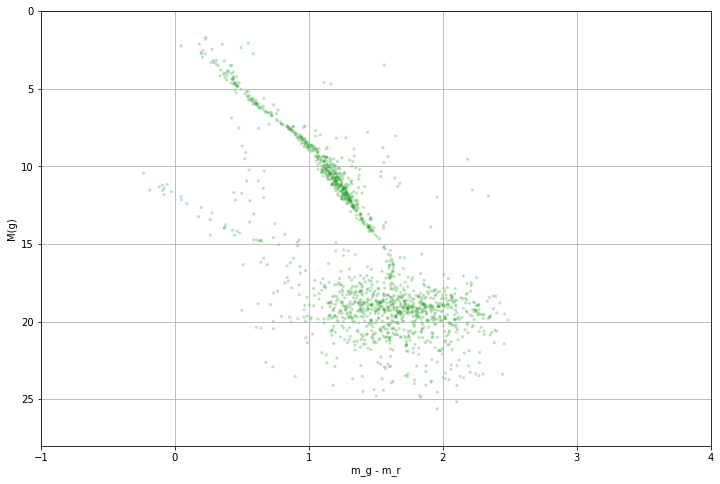

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(dataTable['col10'] - dataTable['col11'], dataTable['col9'],  c=color, s=10, label=color,
               alpha=0.3, edgecolors='none')
plt.xlim(-1, 4)
plt.ylim(28,0)
plt.xlabel('m_g - m_r')
plt.ylabel('M(g)')
ax.grid(True)

plt.show()

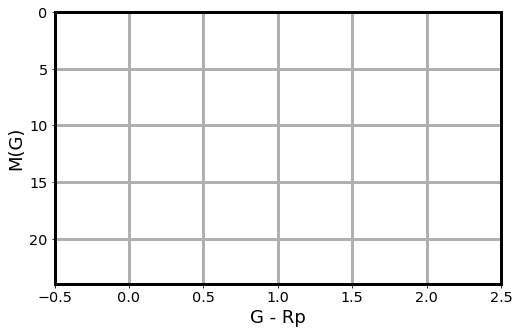

In [332]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pparams = {'legend.fontsize': 'x-large',
          'figure.figsize': (32, 20),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'axes.linewidth':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
fig, ax = plt.subplots(figsize=(8, 5))
plt.xlim(-0.5, 2.5)
plt.ylim(24,0)
plt.setp(ax.spines.values(), linewidth=3)
plt.xlabel('G - W2', fontsize=18)
plt.ylabel('M(G)', fontsize=18)
ax.grid(True, linewidth=3)
plt.savefig('axes.png',dpi=150)
plt.show()


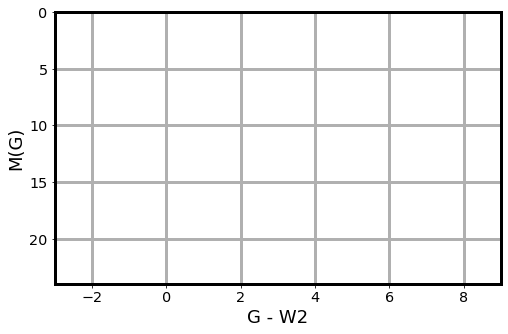

In [351]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.xlim(-3.0, 9.0)
plt.ylim(24,0)
plt.setp(ax.spines.values(), linewidth=3)
plt.xlabel('G - W2', fontsize=18)
plt.ylabel('M(G)', fontsize=18)
ax.grid(True, linewidth=3)
plt.savefig('axes2.png',dpi=150)
plt.show()

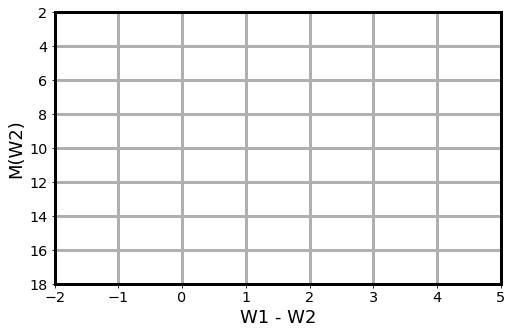

In [353]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.xlim(-2.0, 5.0)
plt.ylim(18,2)
plt.setp(ax.spines.values(), linewidth=3)
plt.xlabel('W1 - W2', fontsize=18)
plt.ylabel('M(W2)', fontsize=18)
ax.grid(True, linewidth=3)
plt.savefig('axes3.png',dpi=150)
plt.show()

In [130]:
from astropy.io import fits

In [138]:
hdu_list = fits.open('gaiadr2_20pc.fits')

In [140]:
print(hdu_list[1].columns)

ColDefs(
    name = 'solution_id'; format = 'K'
    name = 'designation'; format = '28A'
    name = 'source_id'; format = 'K'
    name = 'random_index'; format = 'K'
    name = 'ref_epoch'; format = 'D'; unit = 'yr'
    name = 'ra'; format = 'D'; unit = 'deg'
    name = 'ra_error'; format = 'D'; unit = 'mas'
    name = 'dec'; format = 'D'; unit = 'deg'
    name = 'dec_error'; format = 'D'; unit = 'mas'
    name = 'parallax'; format = 'D'; unit = 'mas'
    name = 'parallax_error'; format = 'D'; unit = 'mas'
    name = 'parallax_over_error'; format = 'E'
    name = 'pmra'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmra_error'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmdec'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmdec_error'; format = 'D'; unit = 'mas.yr**-1'
    name = 'ra_dec_corr'; format = 'E'
    name = 'ra_parallax_corr'; format = 'E'
    name = 'ra_pmra_corr'; format = 'E'
    name = 'ra_pmdec_corr'; format = 'E'
    name = 'dec_parallax_corr'; format = 'E'
    na

In [141]:
gaia20 = evt_data = Table(hdu_list[1].data)

In [143]:
gaia20

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
int64,str28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,str13,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,str77,str99
1635721458409799680,Gaia DR2 1213916950812872192,1213916950812872192,695746037,2015.5,231.5573541319043,1.4192238665049086,20.726353416859865,0.77660947163052,50.00019778524733,1.484577840190497,33.67974,-220.7752994434754,2.335741446202821,-359.1642444095242,2.0387728895245822,0.33621332,-0.62439746,0.1628184,-0.09110792,-0.07951462,0.11345087,0.016286472,-0.13717677,0.28528294,0.26259515,125,0,124,1,1.4488667,142.02927,2.327548779666554,1.1424918921805174,31,False,0.02336246,1.1948382491385257,0.26663274498618283,0.068131275,15,9,2.1930022,0,15,False,126,98.729507585033,1.1019357283100653,89.59643,20.702248,8,18.377979253384396,4.640258369340068,3.9605508,22.190643,14,224.33625333543768,16.225021147361073,13.826562,18.884672,2.4583757,0,3.3059711,1.4883957,1.8175755,nan,nan,0,nan,nan,nan,NOT_AVAILABLE,31.18138735822661,54.19533291241761,222.41838001860245,38.03114251219066,-9223372036854775808,nan,nan,nan,nan,nan,nan,nan,nan,nan,-9223372036854775808,nan,nan,nan,nan,nan,nan,http://geadata.esac.esa.int/data-server/datalink/links?ID=1213916950812872192,
1635721458409799680,Gaia DR2 6277615871616087040,6277615871616087040,452171331,2015.5,214.3712885378121,0.5717333770723354,-21.094237731275097,0.7004308874464927,50.00630547082087,0.8650395631539287,57.808113,-50.014024419297684,1.181497899897914,-14.364190382109976,1.0934595609373836,-0.39588222,0.3337588,-0.36796376,-0.1436238,-0.73711985,-0.0021908022,0.2560439,-0.21826619,-0.0930515,-0.43946254,79,0,70,9,6.575735,171.22159,1.9572433237359241,8.92382252699037,31,False,0.1456401,1.411973785677892,0.2023455529955654,0.00976242,8,6,1.2086904,0,11,True,80,496.434